# Riemann MCMC (simplified MMALA)

First, let's import `REBOUND`. This version of rebound can integrate the second order variational equations with IAS15, a high accuracy non-symplectic integrator. The only thing that is not yet implemented is varying the mass. Currently the variational particles have the same mass as their real counterparts.

Note that I'll do some refactoring in the code some time soon to change several variable names. Right now, whenever the word *MEGNO* appears, replace it with *variational*.

We also import numpy, scipy (for multidimensional normal distributions) and matplotlib (for plotting).

In [1]:
%matplotlib inline
import rebound as r; r.reset(); r.status()
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import simulation
import observation

---------------------------------
Rebound version:     	1.1.0
Build on:            	Jul  5 2015 21:40:46
Number of particles: 	0
Simulation time:     	0.000000
---------------------------------


## Test observation
Let's run the `generateFakeObs()` routine once, just to see what we are dealing with. 

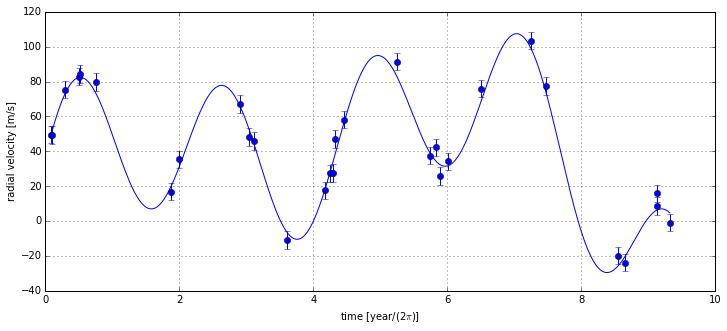

In [3]:
N = 4
theta_names              = ["a_1", "m_1", "anom_1", "a_2", "m_2", "anom_2", "a_3", "m_3"]
theta_test               = [1.,    1e-3,  1.,       .5,    1e-3,  0.3,      2.,   3e-3]
o = observation.FakeObservation(theta_test, theta_names)
fig1 = plt.figure(figsize=(12,5))
times = np.linspace(o.t[0],o.t[-1],500)
s = simulation.Simulation(theta_test, theta_names)
plt.plot(times, s.getRV(times=times), color="b");
plt.ylabel("radial velocity [m/s]"); plt.xlabel("time [year/(2$\pi$)]")
plt.errorbar(o.t, o.rv, yerr=o.err, fmt="bo")
plt.grid()


## Soft-abs metric
The following function implements the soft-abs metric. This makes sure the metric is positive definite and well behaved. I'm not sure yet how to choose `alpha`.

In [4]:
def softabs(hessians):
    lam, Q = np.linalg.eig(-hessians)
    lam_twig = lam*1./np.tanh(alpha*lam)
    H_twig = np.dot(Q,np.dot(np.diag(lam_twig),Q.T))    
    return H_twig

## MCMC loop
This function is the actual MCMC loop. It can be optimized, but it works. It would probably make sense to have some sort of "state object".

In [10]:
class State:  
    N_param = 0
    def __init__(self, thetai, epsiloni):
        self.N_param  = len(thetai)
        self.theta    = thetai
        self.epsilon  = epsiloni
        s = simulation.Simulation(self.theta, theta_names)
        self.logp, self.gradient, self.hessian = s.getLogP(o, derivatives=True) # This is slow.
        self.G        = softabs(self.hessian)
        self.Ginv     = np.linalg.inv(self.G)
        self.Ginvsqrt = np.linalg.cholesky(self.Ginv)    
        self.mu       = self.theta + (self.epsilon)**2 * np.dot(self.Ginv, self.gradient)/2.
        
    def generateProposal(self):
        thetastar = self.mu + (self.epsilon) * np.dot(self.Ginvsqrt, np.random.normal(0.,1.,N_param))
        return State(thetastar,self.epsilon)
    
    def transitionProbability(self,thetaNew):
        return stats.multivariate_normal.logpdf(thetaNew,mean=self.mu, cov=(self.epsilon)**2*self.Ginv)
    
def mcmc(theta,N_steps,epsilon):
    state = State(np.array(theta),epsilon)
    errs = np.zeros(N_steps)
    chain = np.zeros((N_steps,state.N_param))

    accepted = 0
    for i in range(N_steps):
        stateStar = state.generateProposal()

        q_ts_t = state.transitionProbability(stateStar.theta)
        q_t_ts = stateStar.transitionProbability(state.theta)
        
        if np.exp(stateStar.logp-state.logp+q_t_ts-q_ts_t) > np.random.uniform():
            accepted += 1
            state = stateStar
        chain[i] = state.theta
        errs[i] = state.logp

    print "Acceptance rate: %.1f%%" % (float(accepted)/float(N_steps)*100.)
    return errs, chain

## Run!!
Let's setup all parameters, create fake observations and run the MCMC

In [11]:
N                        = 4
N_steps                  = 50
alpha                    = 1.1         # softabs alpha
theta_names              = ["a_1", "m_1", "anom_1", "a_2", "m_2", "anom_2", "a_3", "m_3"]
theta_actual             = [1.,    1e-3,  1.,       .5,    1e-3,  0.3,      2.,   3e-3]
theta_initial            = [1.,    1e-3,  1.,       .5,    1e-3,  0.3,      2.,   3e-3]

epsilon                  = np.power(len(theta_initial),-1./3.)
print "epsilon = %f" % epsilon
# Generate fake observations and run MCMC
o = observation.FakeObservation(theta_actual, theta_names)
errs, chain = mcmc(theta_initial,N_steps, epsilon=epsilon)

epsilon = 0.500000


ValueError: cannot remove a zero-sized axis from an iterator

## Plots
Let's plot the evolution of the chain: logp, and all parameters. Green lines correspond to the actual values used to generate the observations.

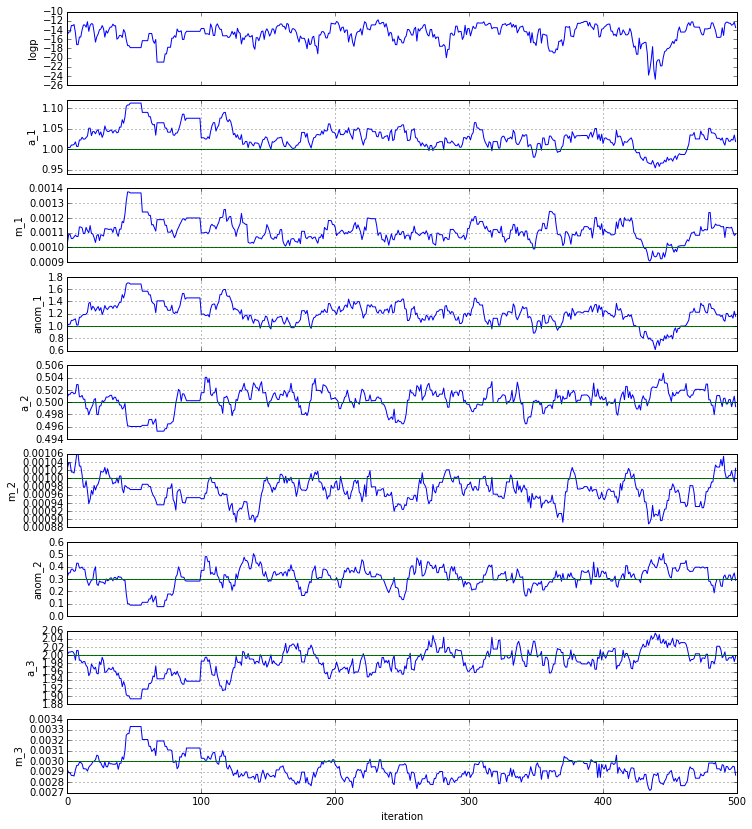

In [18]:
fig1 = plt.figure(figsize=(12,14))
ax1 = plt.subplot(N_param+1,1,1)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel("logp");
plt.plot(range(N_steps), errs, color="b");
for i in range(N_param):
    ax = plt.subplot(N_param+1,1,i+2, sharex=ax1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.ylabel(theta_names[i]);
    plt.plot(range(N_steps), chain[:,i], color="b");
    plt.plot([0,N_steps-1], [theta_actual[i],theta_actual[i]], color="g");
    plt.grid();
plt.xlabel("iteration")
plt.setp(ax.get_xticklabels(), visible=True);

## Autocorrelation plots

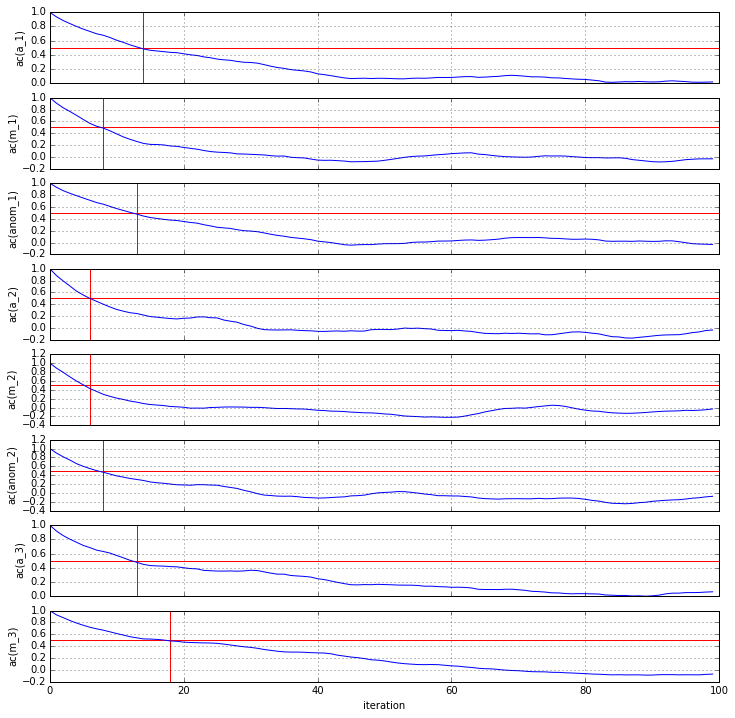

In [20]:
def autocorr(x):
    result = np.correlate(x, x, mode="full")
    return result[result.size/2:]

fig, axes = plt.subplots(figsize=(12,12),nrows=N_param, sharex=True)
plt.xlabel("iteration");

for i in range(N_param):
    cor = autocorr(chain[:,i]-np.mean(chain[:,i]))
    cor = cor/cor[0]
    axes[i].set_ylabel("ac("+theta_names[i]+")");
    showSteps = min(100,N_steps)
    half = 0
    for j,c in enumerate(cor):
        if c<0.5:
            half = j
            break
    axes[i].grid()
    axes[i].axvline(half, color="r")
    axes[i].axhline(0.5, color="r")
    axes[i].plot(range(N_steps)[:showSteps], cor[:showSteps], color="b");
    

## Triangle plot

Let's make a triangle plot of the distributions. The plot also shows the actual (true) values.

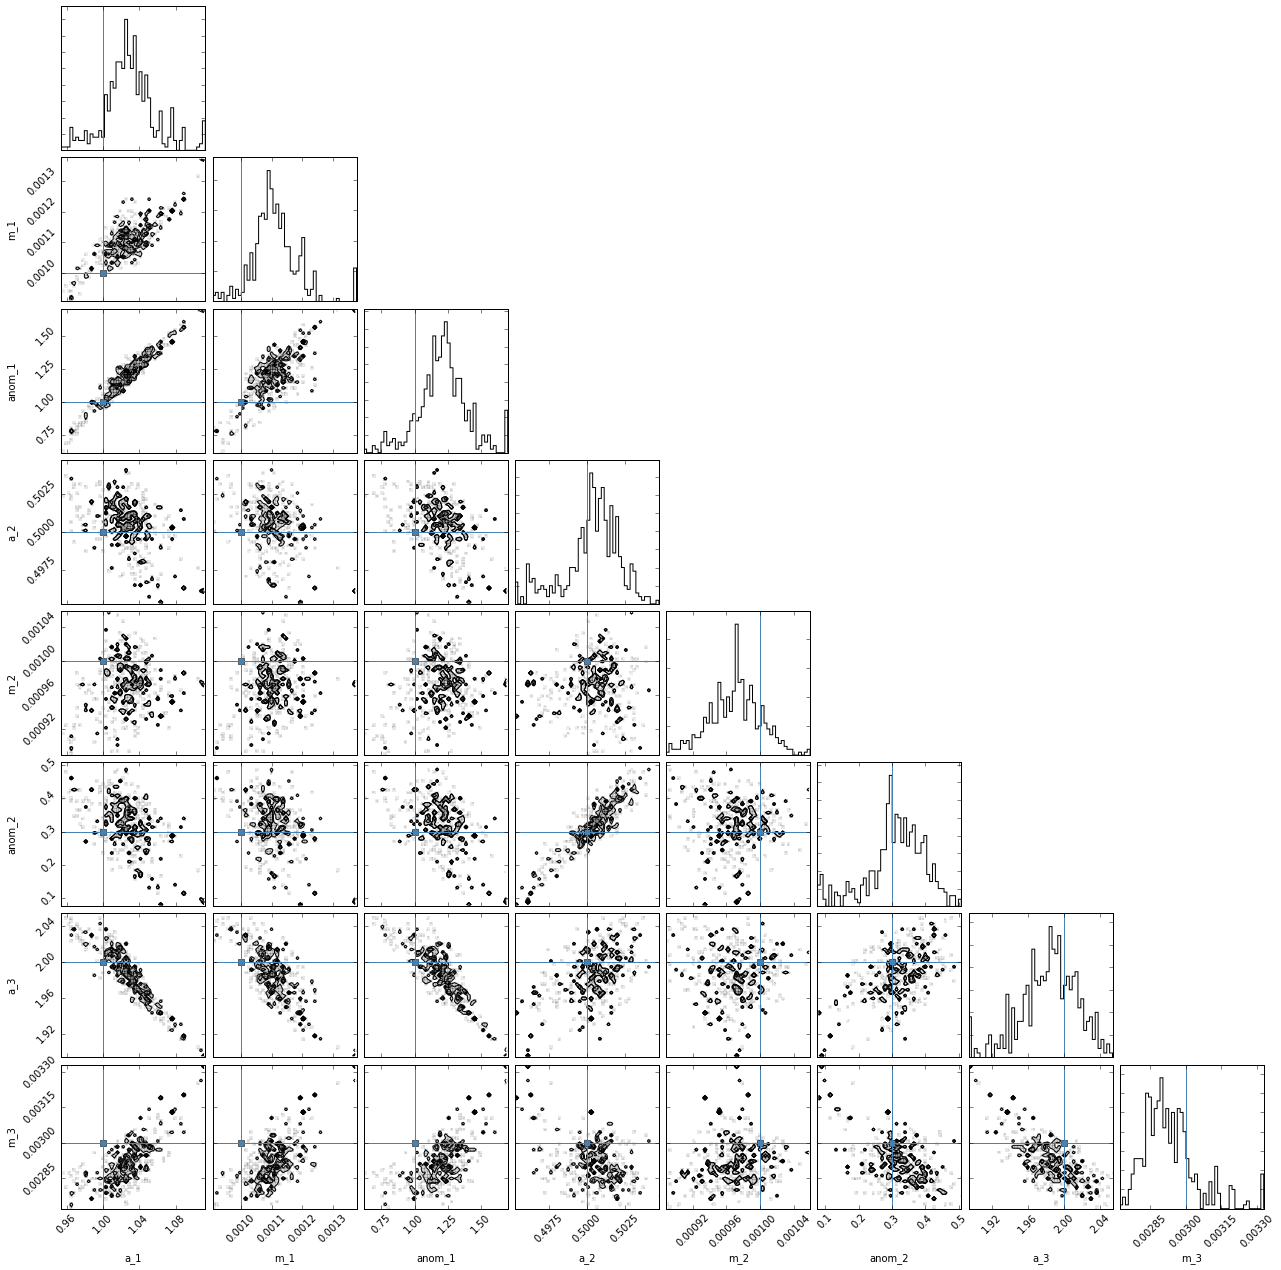

In [21]:
import triangle
figure = triangle.corner(chain, labels=theta_names, truths=theta_actual)

To inspect the evolution, here is a dynamic widget plot, the slider can be used to scan through the iterations and compare the RV curve to the actual observations (only works in an active jupyter notebook).

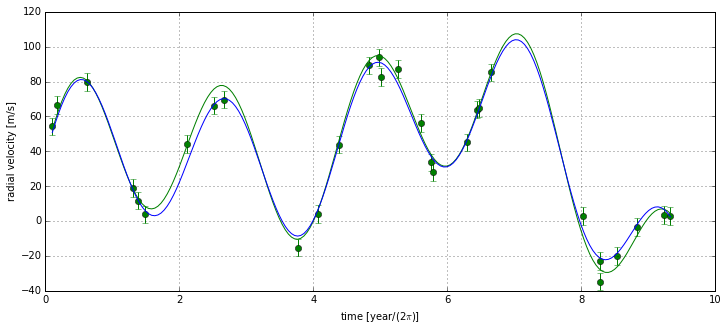

In [22]:
from IPython.html.widgets import interact, interactive
from IPython.display import display
times = np.linspace(data_t[0],data_t[-1],200)

def widgetplot(ind):
    fig1 = plt.figure(figsize=(12,5))
    plt.ylabel("radial velocity [m/s]"); plt.xlabel("time [year/(2$\pi$)]")
    plt.errorbar(data_t, data_rv, yerr=data_err, fmt="go")
    plt.plot(times, getRV(theta_actual, times=times), color="g");
    plt.plot(times, getRV(chain[int(ind),:], times=times), color="b");
    plt.grid()

display(interactive(widgetplot, ind=(0,N_steps-1)))